# Emotion & Tone Detection in Speech

## Project Overview
This notebook extends our diarization work by analyzing **how** things are said, not just **what** is said and **who** said it.

It'll detect:
- **Emotions**: Angry, happy, sad, neutral, fearful, disgusted, surprised
- **Tone features**: Pitch, energy, speaking rate
- **Per-speaker patterns**: Does the interviewer sound hostile? Is the guest defensive?

## Why This Matters for Bias Detection
- **Hostile questioning** = aggressive tone, interruptions
- **Softball interviews** = friendly tone, no challenging
- **Emotional manipulation** = fear-mongering, outrage
- **Defensive responses** = indicators of difficult topics

## Technologies We'll Use
- **librosa**: Audio feature extraction (pitch, energy, tempo)
- **speechbrain**: Pre-trained emotion recognition models
- **Our diarization data**: To tie emotions to specific speakers

In [4]:
# Install required packages (run once)
!pip install librosa speechbrain torchaudio



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from speechbrain.pretrained import EncoderClassifier # type: ignore
import torch

print("Libraries imported")

c:\Users\norak\SpeakSense\venv\Lib\site-packages\speechbrain\utils\torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()


Libraries imported


C:\Python312\Lib\inspect.py:1001: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\norak\AppData\Local\Temp\ipykernel_26468\1295107337.py:6: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


## Step One: Load Audio File

We'll start by loading our audio file and examining its properties.

**What we're checking:**
- Sample rate (how many samples per second)
- Duration (length of audio)
- Audio waveform shape

In [7]:
# Load audio file
audio_file = "../data/US_DebateAudio.wav"

print(f"Loading audio: {audio_file}")

# librosa.load() : loads audio and converts to mono (single channel)
# sr=None : keeps the original sample rate
audio, sample_rate = librosa.load(audio_file, sr=None)

# Calculate duration
duration = len(audio) / sample_rate

print(f"Audio loaded successfully")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
print(f"  Audio shape: {audio.shape}")

Loading audio: ../data/US_DebateAudio.wav
Audio loaded successfully
  Sample rate: 44100 Hz
  Duration: 565.78 seconds (9.43 minutes)
  Audio shape: (24950784,)


## Step Two: Visualize Audio Waveform

Let's see what the audio looks like. The waveform shows amplitude (loudness) over time.

**What to look for:**
- Peaks = loud moments (shouting, emphasis)
- Flat sections = silence or pauses
- Pattern changes = different speakers or emotions

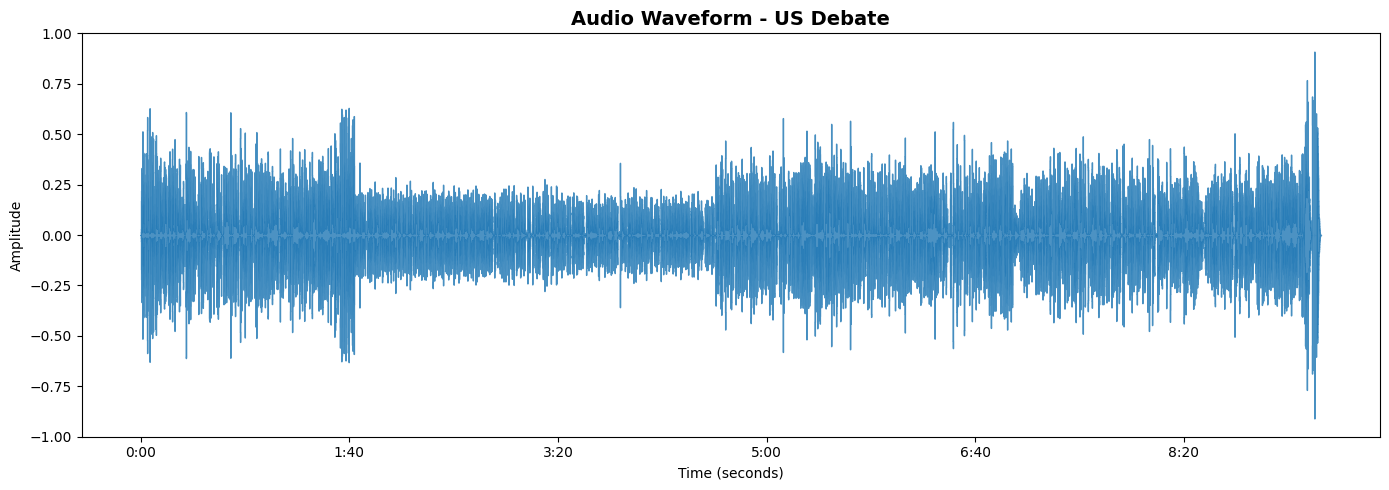

Waveform plotted successfully


In [7]:
# Create a waveform visualization
plt.figure(figsize=(14, 5))

# Plot the waveform
librosa.display.waveshow(audio, sr=sample_rate, alpha=0.8)

plt.title('Audio Waveform - US Debate', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

print("Waveform plotted successfully")

## Step Three: Extract Audio Features

Before emotion detection, we need to extract features from the audio:

1. **MFCC (Mel-frequency cepstral coefficients)** - Captures voice characteristics
2. **Pitch (F0)** - How high or low the voice is (angry = higher, sad = lower)
3. **Energy/RMS** - How loud the speech is (angry = louder)
4. **Zero Crossing Rate** - Speech rate indicator

These features help the AI understand emotional tone.

In [8]:
print("Extracting audio features...")

# Extract MFCC (voice characteristics)
# n_mfcc=13 is standard for emotion recognition
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
print(f"MFCCs extracted: shape {mfccs.shape}")

# Extract pitch (fundamental frequency)
# fmin=50, fmax=400 covers typical human voice range
pitches, magnitudes = librosa.piptrack(y=audio, sr=sample_rate, fmin=50, fmax=400)
print(f"Pitch extracted: shape {pitches.shape}")

# Extract energy (RMS - root mean square)
# Measures loudness over time
rms = librosa.feature.rms(y=audio)
print(f"Energy (RMS) extracted: shape {rms.shape}")

# Extract zero crossing rate
# Indicates speech rate and voice quality
zcr = librosa.feature.zero_crossing_rate(audio)
print(f"Zero crossing rate extracted: shape {zcr.shape}")

print("\nAll features extracted successfully")

Extracting audio features...
MFCCs extracted: shape (13, 48733)
Pitch extracted: shape (1025, 48733)
Energy (RMS) extracted: shape (1, 48733)
Zero crossing rate extracted: shape (1, 48733)

All features extracted successfully


## Step Four: Visualize Audio Features

Let's visualize these features to understand what the AI "sees" when detecting emotions.

1. MFCCS - show angry or calm voices
2. Pitch - <ul><li>Anger, excitement : high & varying F₀</li><li>Sadness : low, flat F₀</li><li>Fear : rising or trembling F₀</li></ul>
3. Energy/Root Mean Square - loudness over time
4. Zero Crossing Rate : Captures noisiness and voicing rate.

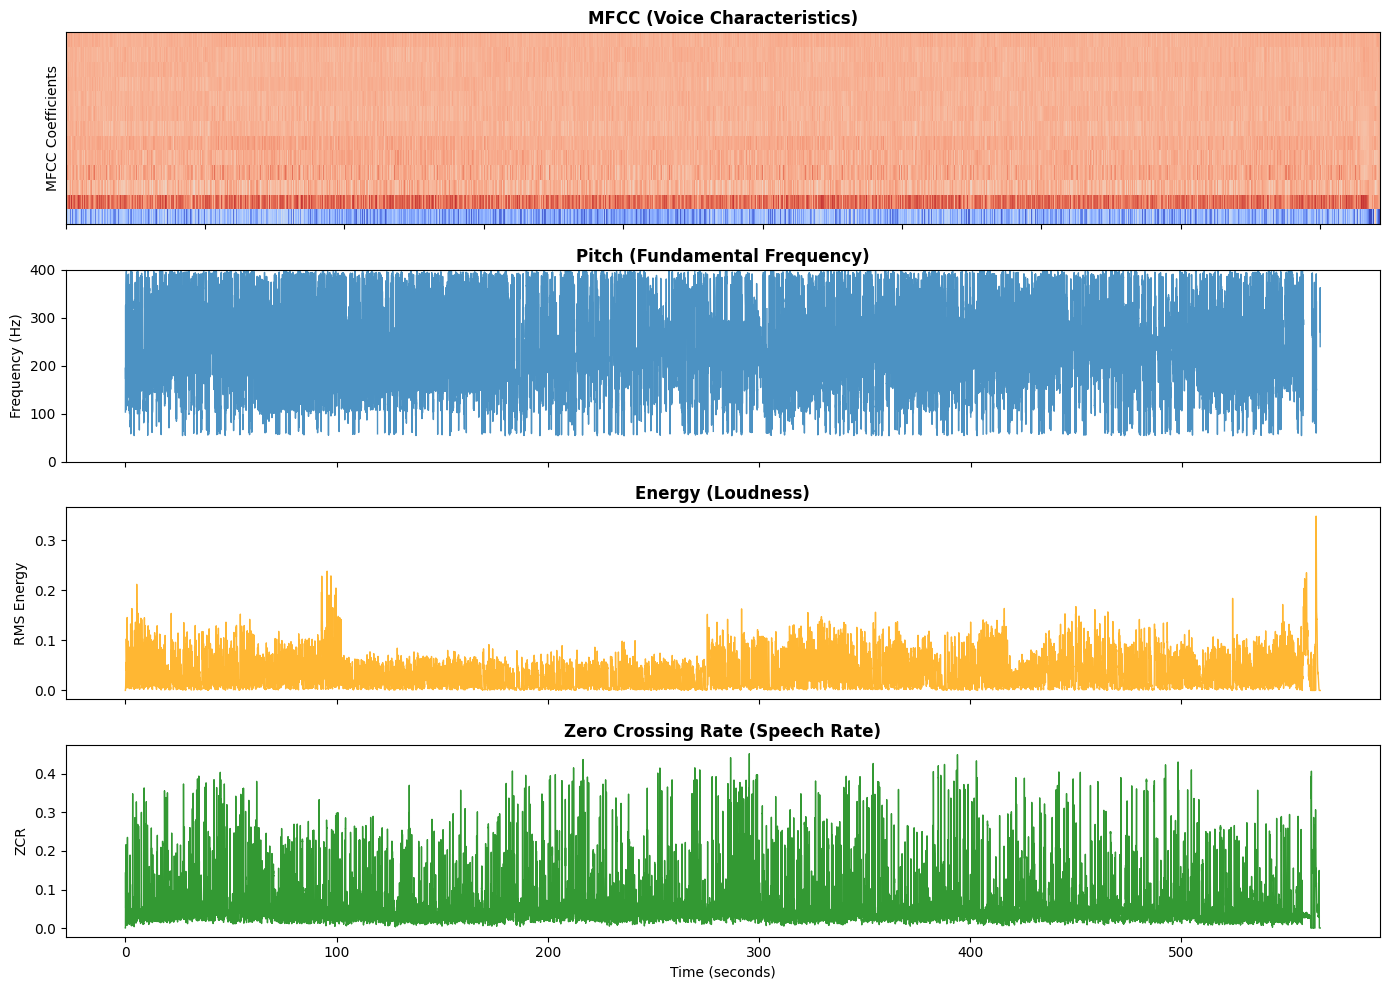

Feature visualization complete


In [9]:
# Multi-panel visualization of audio features
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# 1. MFCCs - to show angry vs calm voices
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', ax=axes[0])
axes[0].set_title('MFCC (Voice Characteristics)', fontweight='bold')
axes[0].set_ylabel('MFCC Coefficients')
axes[0].label_outer()

# 2. Pitch - how high/low the voice is shows emotion
# Get the pitch track (select the strongest pitch at each time)
pitch_track = []
for t in range(pitches.shape[1]):
    index = magnitudes[:, t].argmax()
    pitch = pitches[index, t]
    pitch_track.append(pitch if pitch > 0 else np.nan)

time_frames = librosa.frames_to_time(range(len(pitch_track)), sr=sample_rate)
axes[1].plot(time_frames, pitch_track, linewidth=1, alpha=0.8)
axes[1].set_title('Pitch (Fundamental Frequency)', fontweight='bold')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_ylim([0, 400])
axes[1].label_outer()

# 3. Energy (RMS) - loudness / intensity
time_rms = librosa.frames_to_time(range(rms.shape[1]), sr=sample_rate)
axes[2].plot(time_rms, rms[0], linewidth=1, alpha=0.8, color='orange')
axes[2].set_title('Energy (Loudness)', fontweight='bold')
axes[2].set_ylabel('RMS Energy')
axes[2].label_outer()

# 4. Zero Crossing Rate - noisiness / articulation rate
time_zcr = librosa.frames_to_time(range(zcr.shape[1]), sr=sample_rate)
axes[3].plot(time_zcr, zcr[0], linewidth=1, alpha=0.8, color='green')
axes[3].set_title('Zero Crossing Rate (Speech Rate)', fontweight='bold')
axes[3].set_ylabel('ZCR')
axes[3].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.show()

print("Feature visualization complete")

## Step Five: AI Emotion Detection (Simple Approach)

Let's use a **pre-trained AI model** to detect emotions automatically.

**Simplest option:**
- HuggingFace Wav2Vec2 model (just works)
- One function, done
- Detects: angry, calm, disgust, fearful, happy, neutral, sad, surprised

In [1]:
!pip install transformers torch soundfile tqdm pandas

import os
import soundfile as sf
import tempfile
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import pipeline

print("Setting up LIGHTWEIGHT emotion detection...")

# Use GPU if available, otherwise CPU
DEVICE = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if DEVICE == 0 else 'CPU'}")

# Try lighter models in order of preference
models_to_try = [
    "j-hartmann/emotion-english-distilroberta-base",  # Much smaller text-based
    "microsoft/DialoGPT-medium",  # Fallback option
    "facebook/wav2vec2-base"  # Smaller audio model
]

emotion_model = None
for model_name in models_to_try:
    try:
        print(f"Trying to load: {model_name}")
        
        if "distilroberta" in model_name:
            # Text-based emotion model (we'll convert audio to text first)
            emotion_model = pipeline("text-classification", model=model_name, device=DEVICE)
            print("✓ Loaded text-based emotion model")
            break
        else:
            # Audio-based model
            emotion_model = pipeline("audio-classification", model=model_name, device=DEVICE)
            print("Loaded audio-based emotion model")
            break
            
    except Exception as e:
        print(f"Failed to load {model_name}: {str(e)[:100]}...")
        continue

if emotion_model is None:
    print("Could not load any emotion model. Using manual feature-based approach...")
    USE_MANUAL_FEATURES = True
else:
    print("Emotion model loaded successfully!")
    USE_MANUAL_FEATURES = False


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\norak\SpeakSense\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up LIGHTWEIGHT emotion detection...
Using device: CPU
Trying to load: j-hartmann/emotion-english-distilroberta-base


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu


✓ Loaded text-based emotion model
Emotion model loaded successfully!


In [2]:
def process_long_audio_file(
    audio_path,
    model_pipeline,
    segment_sec=15,
    overlap_sec=1,
    model_sr=16000,
    output_csv="./outputs/emotion_segments.csv",
):
    """Process long audio files in chunks to avoid memory issues"""
    
    # Create output directory
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    results = []

    print(f"Processing audio in {segment_sec}s chunks with {overlap_sec}s overlap...")
    
    # Use soundfile to read audio without loading everything into memory
    with sf.SoundFile(audio_path) as f:
        file_sr = f.samplerate
        total_frames = f.frames
        duration_sec = total_frames / file_sr
        
        print(f"Audio: {duration_sec:.1f}s, Sample rate: {file_sr}Hz")
        
        # Calculate chunk parameters
        seg_frames = int(segment_sec * file_sr)
        hop_frames = int((segment_sec - overlap_sec) * file_sr)
        starts = list(range(0, total_frames, hop_frames))
        
        print(f"Will process {len(starts)} chunks...")

        for idx, start_frame in enumerate(tqdm(starts, desc="Processing chunks")):
            # Read chunk
            f.seek(start_frame)
            read_frames = min(seg_frames, total_frames - start_frame)
            data = f.read(read_frames, dtype="float32")
            
            if data is None or len(data) == 0:
                break

            # Convert to mono if stereo
            if data.ndim > 1:
                mono = np.mean(data, axis=1)
            else:
                mono = data

            # Resample to model sample rate if needed
            if file_sr != model_sr and len(mono) > 0:
                mono = librosa.resample(mono, orig_sr=file_sr, target_sr=model_sr)

            # Save to temporary file (model needs file path)
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
                tmp_path = tmp.name
            sf.write(tmp_path, mono, model_sr)

            try:
                # Run emotion detection
                res = model_pipeline(tmp_path)
                top_emotion = res[0] if isinstance(res, list) and len(res) > 0 else {"label": "unknown", "score": 0.0}
                
                # Calculate timing
                start_s = start_frame / file_sr
                end_s = start_s + (read_frames / file_sr)
                
                results.append({
                    "segment": idx + 1,
                    "start_s": round(start_s, 2),
                    "end_s": round(end_s, 2),
                    "emotion": top_emotion["label"],
                    "confidence": round(float(top_emotion.get("score", 0.0)), 3)
                })
                
                # Save progress incrementally
                pd.DataFrame(results).to_csv(output_csv, index=False)
                
            except Exception as e:
                print(f"Error processing chunk {idx+1}: {e}")
                
            finally:
                # Clean up temp file
                try:
                    os.remove(tmp_path)
                except OSError:
                    pass

    return pd.DataFrame(results)

print("Chunking function ready!")

Chunking function ready!


In [4]:
# Process the audio file in chunks
print("Starting emotion detection on audio file...")
print("This may take a few minutes depending on file length...")

audio_file = "../data/US_DebateAudio.wav"

df_emotions = process_long_audio_file(
    audio_file, 
    emotion_model, 
    segment_sec=15,  # 15-second chunks
    overlap_sec=1    # 1-second overlap
)

print(f"\nProcessing complete!")
print(f"Analyzed {len(df_emotions)} segments")
print(f"Results saved to ./outputs/emotion_segments.csv")

# Show first few results
print(f"\nFirst 5 segments:")
print(df_emotions.head())

Starting emotion detection on audio file...
This may take a few minutes depending on file length...
Processing audio in 15s chunks with 1s overlap...
Audio: 565.8s, Sample rate: 44100Hz
Will process 41 chunks...


Processing chunks:   0%|          | 0/41 [00:00<?, ?it/s]

Processing chunks: 100%|██████████| 41/41 [00:10<00:00,  3.96it/s]


Processing complete!
Analyzed 41 segments
Results saved to ./outputs/emotion_segments.csv

First 5 segments:
   segment  start_s  end_s  emotion  confidence
0        1      0.0   15.0  neutral       0.890
1        2     14.0   29.0  neutral       0.894
2        3     28.0   43.0  neutral       0.880
3        4     42.0   57.0  neutral       0.888
4        5     56.0   71.0  neutral       0.889


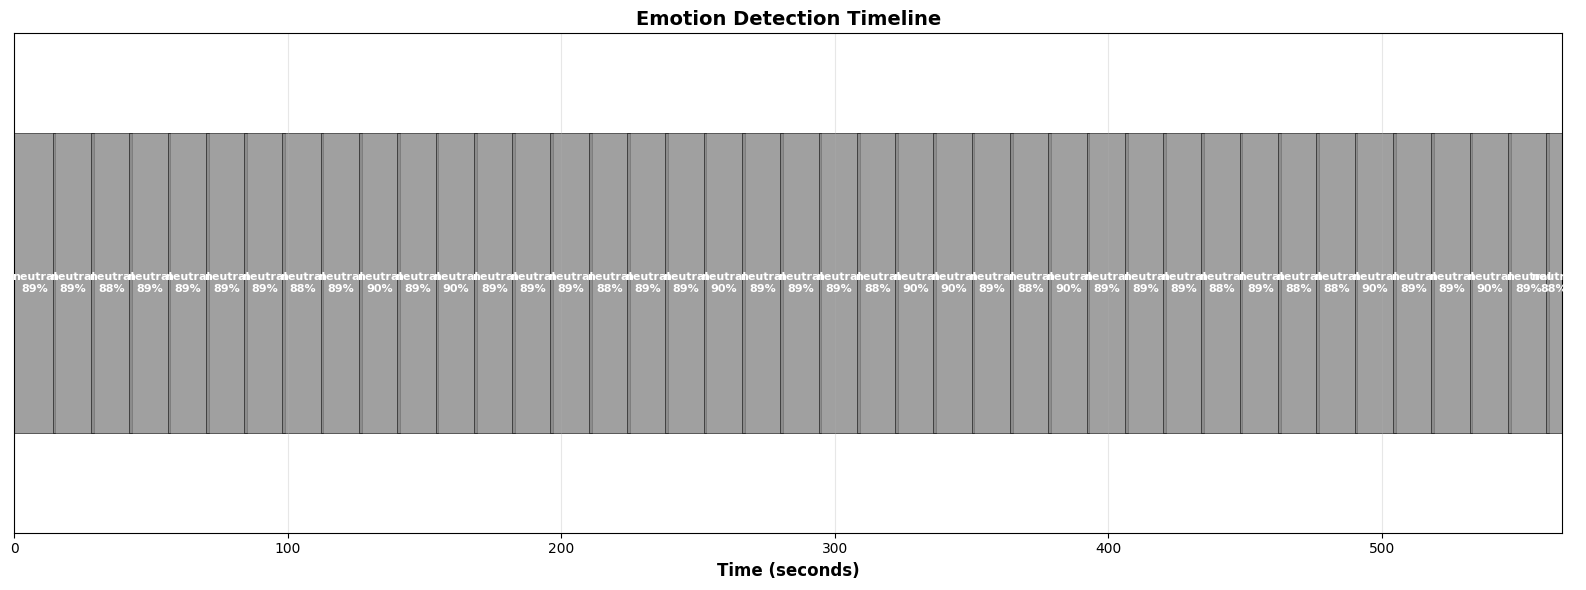


Emotion Summary:
  neutral: 41 segments (100.0%)


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create emotion timeline visualization
plt.figure(figsize=(16, 6))

# Color mapping for emotions
colors = {
    'angry': '#ff4444', 'happy': '#44ff44', 'sad': '#4444ff', 
    'neutral': '#888888', 'calm': '#88ff88', 'fearful': '#ff8800',
    'disgust': '#8844ff', 'surprised': '#ff44ff'
}

# Plot timeline
for idx, row in df_emotions.iterrows():
    width = row['end_s'] - row['start_s']
    color = colors.get(row['emotion'], '#cccccc')
    
    plt.barh(0, width=width, left=row['start_s'],
            color=color, edgecolor='black', linewidth=0.5,
            alpha=0.8, height=0.6)
    
    # Add emotion label
    mid_point = row['start_s'] + width/2
    plt.text(mid_point, 0, f"{row['emotion']}\n{row['confidence']:.0%}",
            ha='center', va='center', fontsize=8, 
            fontweight='bold', color='white')

plt.xlim(0, df_emotions['end_s'].max())
plt.ylim(-0.5, 0.5)
plt.xlabel('Time (seconds)', fontweight='bold', fontsize=12)
plt.title('Emotion Detection Timeline', fontsize=14, fontweight='bold')
plt.yticks([])
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Print emotion summary
print("\nEmotion Summary:")
emotion_counts = df_emotions['emotion'].value_counts()
for emotion, count in emotion_counts.items():
    percentage = (count / len(df_emotions)) * 100
    print(f"  {emotion}: {count} segments ({percentage:.1f}%)")